# Goal of the notebook:
```
CARTPOLE PROBLEM
```

* A state in cartpole problem is defined with 4 values - cart position, cart velocity, pole angle, pole angular velocity.

* Action space - Two actions - left and right.

* To make a deep learning based Q-Network that takes states as input and outputs the respective Q-values for every state-action pair.


As we have seen in the update equation of normal Q-value method, the temporal difference term is used as a loss function in the **DQN** method and we can use an optimizer of our choice.

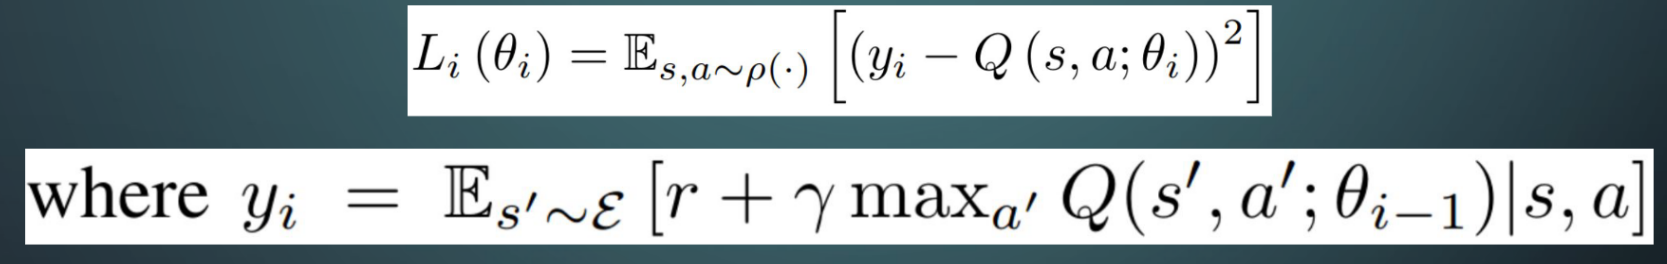

# Imports

In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt

from collections import deque

# Configuring the Cart-Pole environment from OpenAI Gymnasium.

In [2]:
env_name = 'CartPole-v0'
env = gym.make(env_name)

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Defining Q-Net

The idea of defining a Q-Net is to associate every possible state action pair with a Q-value.

In [3]:
class QNet(nn.Module):
    def __init__(self, action_num=2, hidden_size=256):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(4, hidden_size) # 4 values that are needed to define the state
        self.fc2 = nn.Linear(hidden_size, action_num) # To output two values in relation to the two actions associated with the given state information

    def forward(self, x):
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x) # Outputs two values associated with each state
        return q_values

# Replay Buffer

When we attempt to solve Reinforcement learning problems with Deep learning based architectures, neural networks run a risk of "catastrophic forgetting".

In a RL problem, the data the agent is being trained on is not static and is "dynamic" as the agent keeps exploring and is bound to discover new states and respective actions along the way.

For example, when we think about an RL agent trying to play a game, we can see that initially the agent's reward functions would be to help the agent traverse the obstacles in level 1 and reach the goal. Once, we reach the optimal solution, now the agent goes to level 2 with a different set of obstacles and slowly the reward function gets updated to help the agent solve the problems of level 2. If we are training the data sequentially like this, we can see that the problem keeps changing and the agent might lose its skills gained in the initial training experience, if the initial training has not been remembered or revisited.

**Replay Buffer:**
This solves our problem with a simple solution. All the agent's interactions with the environment gets stored in the format of **state, action, reward, next state** in a **FIFO buffer** with a **limited size**. After the replay buffer has been filled, the past experiences are deleted and newer experiences are added to the buffer to facilitate better understanding of the new circumstances around the agent.

In [4]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, mini_batch_size):
        self.data_keys = data_names # Keys of different data we are storing in the replay buffer
        self.data_dict = {} # This is a dictionary in which we store our deques -> double ended queues
        self.buffer_size = buffer_size # Each datatype can store max of this size
        self.mini_batch_size = mini_batch_size
        self.reset() # A reset function defined below to initialize a deque of fixed length for every data variable

    def reset(self):
        # Create a deque for each data type with set max length
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def buffer_full(self):
        return len(self.data_dict[self.data_keys[0]]) == self.buffer_size # Checks if the buffer is full, returns True if Full

    def data_log(self, data_name, data):
      # Responsible for logging the data in the replay buffer

        # split tensor along batch into a list of individual datapoints
        data = data.cpu().split(1) # split(1) splits the data across first dimensions i.e., [0]. So, we get individual datapoints (individual rows)

        # Extend the deque for data type, deque will handle popping old data to maintain buffer size automatically
        self.data_dict[data_name].extend(data) # Same as appending

    def __iter__(self):
        batch_size = len(self.data_dict[self.data_keys[0]]) # Batch is the entire data from buffer
        batch_size = batch_size - batch_size % self.mini_batch_size # How many complete minibatches can be formed from the entire batch, remove incomplete ones

        ids = np.random.permutation(batch_size) # Generating random array of size and values as no. of elements in the batch to form ids from 0 to [batch_size-1]
        ids = np.split(ids, batch_size // self.mini_batch_size) # batch_size // mini_batch_size is how many minibatches we have in the entire batch
        # Splits the shuffled indices into groups of size mini_batch_size.

        for i in range(len(ids)):
            batch_dict = {} # Creating a batch dict to store the batched data or in other words- mini batches of data
            for name in self.data_keys: # For all the data in the buffer
                c = [self.data_dict[name][j] for j in ids[i]] # See respective values from the original buffer of the respective id
                batch_dict[name] = torch.cat(c) # concatenate data respective to that specific variable type in the minibatch
            batch_dict["batch_size"] = len(ids[i]) # Add the batch size key as well to the minibatch
            yield batch_dict # "yield" is used to feed a counter to the training model
            # yield returns a value and pauses
            # The next time it gets asked, it returns the next set of values
            # So, instead of making all the minibatches in advance and sending them at once,
            # We can generate mini-batch by mini-batch when asked for it by the training function.

    def __len__(self):
        return len(self.data_dict[self.data_keys[0]]) #

# Test agent

The testing code that uses the trained Q-network to make inferences on a single trajectory.

* Also used to compute the score in a given trajectory by computing total rewards accumulated through out the episode.

In [5]:
def test_agent():
    done = False
    total_reward = 0
    observation = torch.FloatTensor(env.reset()).unsqueeze(0) # Initial state

    with torch.no_grad():
        while not done: # done when the episode is complete
            q_values = q_net(observation) # Send the state as input
            action = q_values.argmax().cpu().item() # Get two values and take the action corresponding to the highest value
            observation, reward, done, info = env.step(action) # step in Gym is taking the action at current state
            # observation -> next state upon taking respective action
            # reward # done -> done with the episode?
            # info -> extra information
            observation = torch.FloatTensor(observation).unsqueeze(0) # converting into a torch tensor and unsqueeze to inclue bs dimension
            total_reward += reward

    return total_reward

# DQN update

Here is where

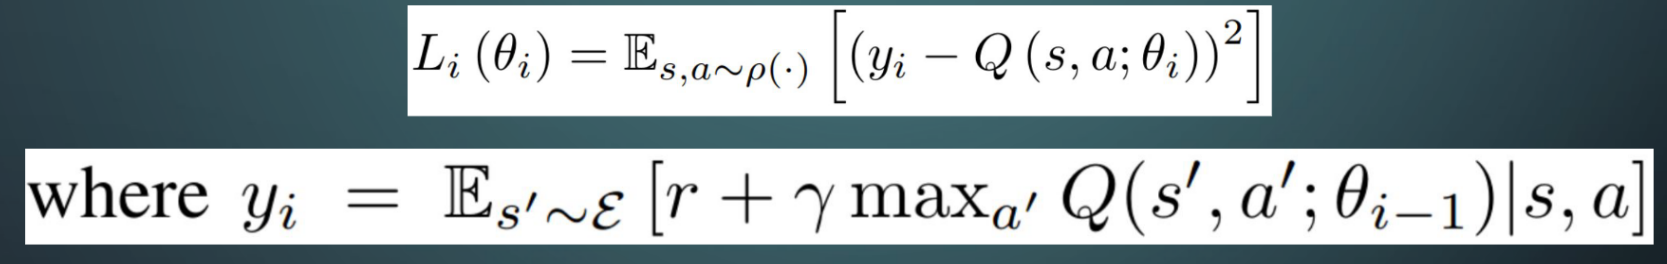

In [6]:
def dqn_update():
    for data_batch in replay_buffer:
        next_q_values = q_net(data_batch["next_states"]).detach()
        # Takes in states data from the replay buffer and pass through qnet to get Q-values associated with actions
        # First calculating the Q-value of the future state (in other words estimation)
        # .detach() ensures that gradients are not computed for these values since they are used as fixed targets.

        q_values = q_net(data_batch["states"])
        # Q-values of the current state

        index_q_values = q_values.gather(1, data_batch["actions"])
        # q_values -> Q-values of all possible actions in the given current state
        # But, an action is chosen at a particular time step during training
        # Here, we are extracting the Q-value of the corresponding action that is taken at the given time step.
        # tensor.gather(dim,index) -> collects the value at a specific "index" of a tensor in a given dimension "dim"

        max_next_q_values = next_q_values.max(1)[0].unsqueeze(1)
        # Max next Q-value -> Q-value corresponding to the best action at next state.

        expected_q_value = data_batch["rewards"] + gamma * max_next_q_values * data_batch["masks"]
        # data_batch["masks"] -> 0 or 1 depending on if we reach the terminal state
        # If we reach the terminal state in the next state, there is no need to propogate Q-values further
        # Hence, we make this value as 0 and we are just left with rewards term for that state

        # Calculating the loss value -> Temporal difference term
        q_loss = (index_q_values - expected_q_value).pow(2).mean()

        # Optimizer
        optimizer.zero_grad()
        q_loss.backward()
        optimizer.step()

In [7]:
lr = 1e-2
gamma = 0.99
buffer_size = 2000
mini_batch_size = 32
max_steps = 15000

# data keys we need to store with in the replay buffer
data_names = ["states", "next_states", "actions", "rewards", "masks"]

# Instantiating Q-Network
q_net = QNet()

# Setting up optimizer
optimizer = optim.Adam(q_net.parameters(), lr=lr)

# Replay buffer creation
replay_buffer = ReplayBuffer(data_names, buffer_size, mini_batch_size)

In [8]:
rollouts = 0
step = 0
initial_epsilon = 1
epsilon = initial_epsilon
score_logger = []

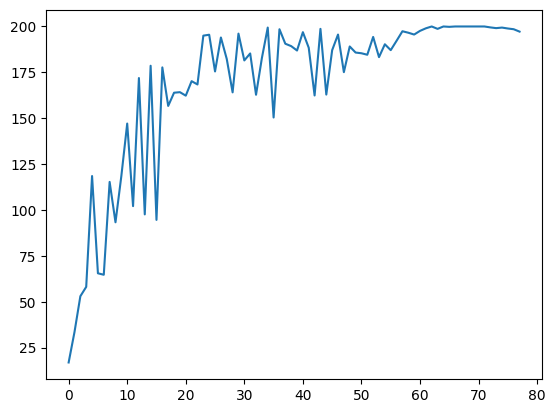

In [9]:
import random
import torch
import cv2
import numpy as np

frames = []  # List to store frames

while step < max_steps: # step means the total number of steps across all episodes.
    observation = torch.FloatTensor(env.reset()).unsqueeze(0) # Resetting when starting an episode
    done = False

    states = []
    rewards = []
    actions = []
    masks = []

    while not done:
        states.append(observation)

        if random.random() > epsilon: # When a random no. is greater than epsilon, Exploit
            q_values = q_net(observation) # Taking the Q-values of the observation
            action = q_values.argmax().reshape(-1, 1) # and choosing action based on max Q-value
        else:
            action = torch.LongTensor([env.action_space.sample()]).reshape(-1, 1) # Random action from action sample space

        observation, reward, done, info = env.step(action.cpu().item()) #Taking the action in the gym environment

        reward = torch.FloatTensor([reward]).unsqueeze(0)

        rewards.append(reward)
        actions.append(action)
        masks.append(torch.FloatTensor([1 - done]).unsqueeze(0)) # When done is 1, means we are done with episode, mask=0
        observation = torch.FloatTensor(observation).unsqueeze(0)

        # Store the frame as RGB array
        frame = env.render(mode='rgb_array')
        frames.append(frame)  # Append the frame to the list

        step += 1

    states.append(observation) # Final state

    # Logging data in replay buffer of the respective episode
    replay_buffer.data_log("states", torch.cat(states[:-1]))
    replay_buffer.data_log("next_states", torch.cat(states[1:]))
    replay_buffer.data_log("rewards", torch.cat(rewards))
    replay_buffer.data_log("actions", torch.cat(actions))
    replay_buffer.data_log("masks", torch.cat(masks))

    # The model only starts training once the replay buffer is full
    if replay_buffer.buffer_full():
        dqn_update()

        if rollouts % 2 == 0: # Update is happening every two episodes to reduce computational overhead
            new_lr = max(1e-4, ((max_steps - step)/max_steps) * lr)
            # lr decreases with time as steps increase, doesn't get below 1e-4
            epsilon = max(0.2, ((max_steps - step)/max_steps) * initial_epsilon)
            # epsilon decreases with time as steps increase, doesn't get below 0.2

            # updating learning rate in optimizer
            optimizer.param_groups[0]["lr"] = new_lr

            # Calculating score using test_agent() that accumulates rewards and taking in average of 10 such test runs
            # test_agent() just uses exploitation
            score_logger.append(np.mean([test_agent() for _ in range(10)]))

            clear_output(True)
            plt.plot(score_logger)
            plt.show()
    rollouts +=1 # Episode update

env.close()

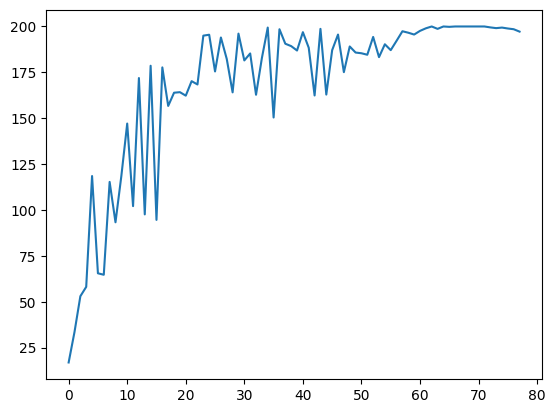

In [11]:
plt.plot(score_logger)

In [10]:
# After training, convert frames to a video
height, width, _ = frames[0].shape
video_name = "cartpole_training.mp4"

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
video_out = cv2.VideoWriter(video_name, fourcc, 30, (width, height))  # 30 FPS

# Write frames to the video
for frame in frames:
    video_out.write(frame)

video_out.release()  # Release the video writer
print(f"Video saved as {video_name}")

Video saved as cartpole_training.mp4
